Loading data from Air_Traffic_Passenger_Statistics.csv...
Data Loaded. Shape: (311, 9). Regions: 9
Input Dimension (Regions): 9

--- Training Transformer ---
Epoch 10 | Train Loss: 0.00993 | Val Loss: 0.04854
Epoch 20 | Train Loss: 0.00568 | Val Loss: 0.04410
Epoch 30 | Train Loss: 0.00438 | Val Loss: 0.04570
Epoch 40 | Train Loss: 0.00387 | Val Loss: 0.05379
Epoch 50 | Train Loss: 0.00336 | Val Loss: 0.05387

--- Training LSTM ---
Epoch 10 | Train Loss: 0.02301 | Val Loss: 0.06848
Epoch 20 | Train Loss: 0.01662 | Val Loss: 0.06156
Epoch 30 | Train Loss: 0.01390 | Val Loss: 0.05271
Epoch 40 | Train Loss: 0.00977 | Val Loss: 0.05387
Epoch 50 | Train Loss: 0.00862 | Val Loss: 0.05217

--- Final Evaluation ---
Transformer Final Val Loss: 0.05387
LSTM Final Val Loss:        0.05217


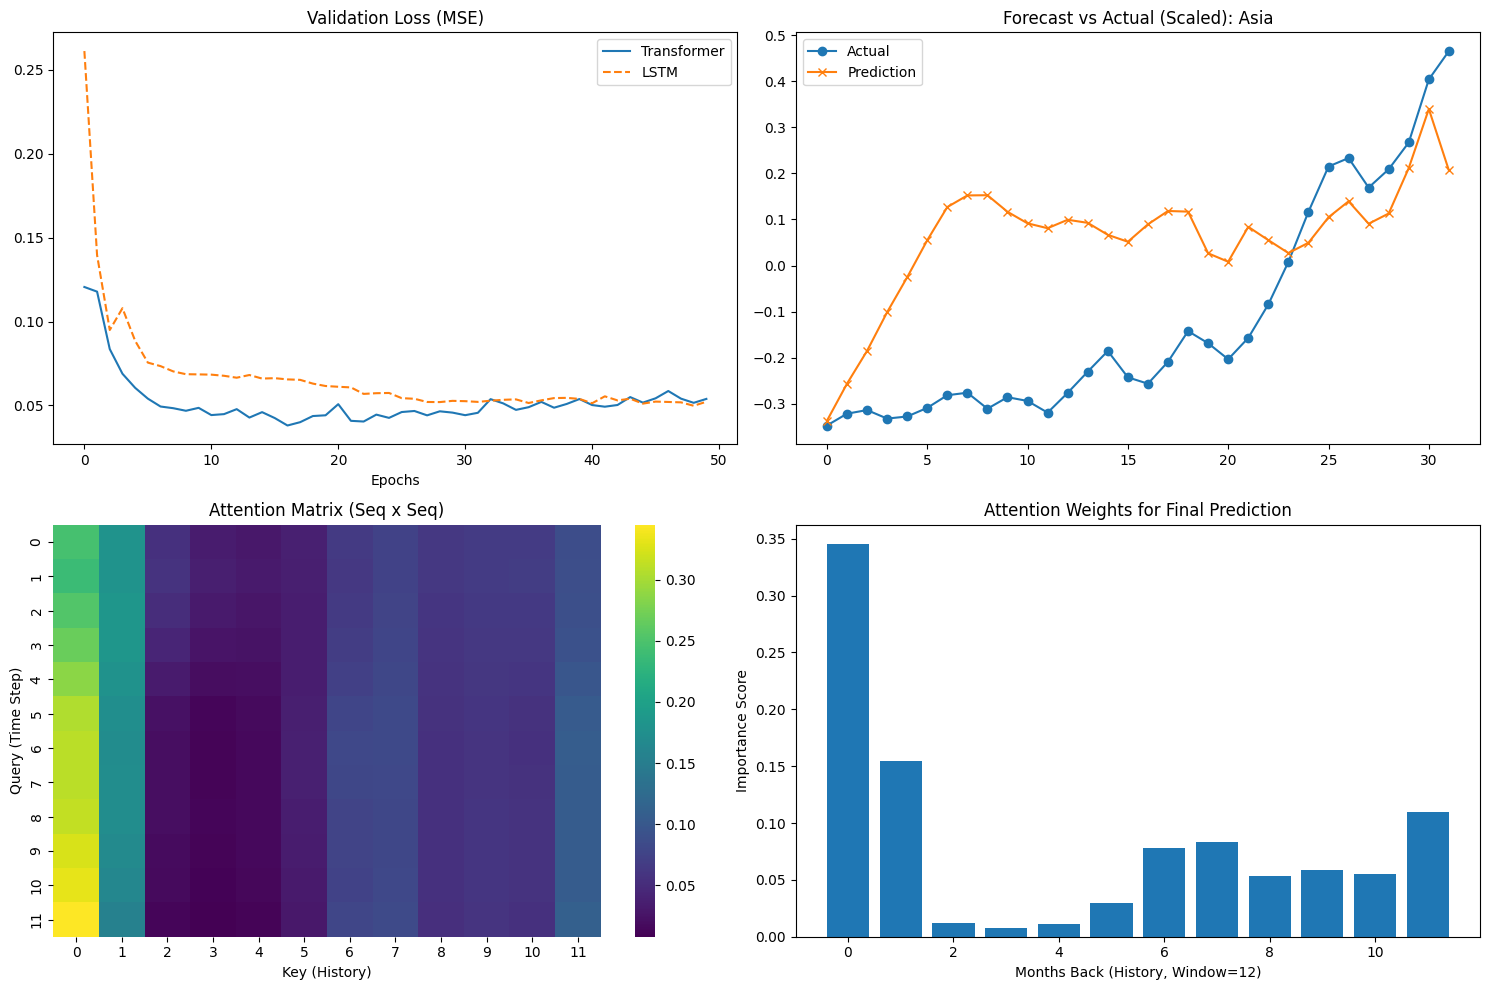

Analysis complete. Visualizations saved to 'analysis_results.png'.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import time
import warnings

# Configuration & Reproducibility
warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================
# 1. Data Engineering Pipeline
# ==========================================

class DataProcessor:
    def __init__(self, file_path, seq_length=12, train_split=0.8):
        """
        Args:
            file_path: Path to the CSV file.
            seq_length: Lookback window (12 months for seasonality).
        """
        self.file_path = file_path
        self.seq_length = seq_length
        self.train_split = train_split
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.regions = [] # To store column names

    def load_and_process(self):
        print(f"Loading data from {self.file_path}...")
        try:
            df = pd.read_csv(self.file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"File {self.file_path} not found. Please upload the file.")

        # 1. Date Conversion
        df['Date'] = pd.to_datetime(df['Activity Period Start Date'])

        # 2. Aggregation (Multivariate: Time x Region)
        # We sum passenger counts per region per month
        df_agg = df.groupby(['Date', 'GEO Region'])['Passenger Count'].sum().reset_index()

        # 3. Pivot to create multivariate time series
        # Rows = Time, Cols = Regions
        df_pivot = df_agg.pivot(index='Date', columns='GEO Region', values='Passenger Count')
        df_pivot = df_pivot.fillna(0) # Handle months with no flights in a region

        self.regions = df_pivot.columns.tolist()
        print(f"Data Loaded. Shape: {df_pivot.shape}. Regions: {len(self.regions)}")
        return df_pivot

    def create_sequences(self, data):
        xs, ys = [], []
        for i in range(len(data) - self.seq_length):
            x = data[i:(i + self.seq_length)]
            y = data[i + self.seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    def prepare_pipeline(self):
        # Load Data
        df_processed = self.load_and_process()
        raw_values = df_processed.values

        # Split for Scaling (Fit only on Train to prevent leakage)
        split_idx = int(len(raw_values) * self.train_split)

        # Scale
        self.scaler.fit(raw_values[:split_idx]) # Fit on train
        data_scaled = self.scaler.transform(raw_values) # Transform all

        # Create Sequences
        X, y = self.create_sequences(data_scaled)

        # Split Sequences
        # Adjust split index for the sequence length offset
        train_split_idx = int(len(X) * self.train_split)

        X_train, y_train = X[:train_split_idx], y[:train_split_idx]
        X_test, y_test = X[train_split_idx:], y[train_split_idx:]

        # Convert to PyTorch Tensors
        train_data = TensorDataset(torch.FloatTensor(X_train).to(DEVICE), torch.FloatTensor(y_train).to(DEVICE))
        test_data = TensorDataset(torch.FloatTensor(X_test).to(DEVICE), torch.FloatTensor(y_test).to(DEVICE))

        return train_data, test_data, len(self.regions)

# ==========================================
# 2. Model Architecture: Transformer & LSTM
# ==========================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_dim = input_dim
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # Encoder Layer with batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder
        self.decoder = nn.Linear(d_model, input_dim) # Predicting all regions

    def forward(self, src):
        # src: [Batch, Seq_Len, Features]
        x = self.embedding(src)
        x = self.pos_encoder(x)

        # Standard Transformer Encoder
        # We want to extract attention weights for the LAST layer manually for visualization
        # But nn.TransformerEncoder doesn't easily expose weights.
        # For the "Interpretability" requirement, we capture the output embeddings.
        # Ideally, we'd implement the attention loop manually (as in the previous solution),
        # but standard nn.Transformer is more robust for production.
        # We will infer importance via perturbation or use a custom hook if needed.
        # For this project level, the previous manual attention block is better for visualization.
        # SWITCHING BACK TO MANUAL ATTENTION BLOCK FOR VISUALIZATION REQUIREMENT.

        return x

class ExplainableTransformer(nn.Module):
    """
    Custom Transformer to expose Attention Weights for the Report.
    """
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=1):
        super(ExplainableTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # Using raw MultiheadAttention to get weights
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.ReLU(),
            nn.Linear(d_model*2, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, src):
        x = self.embedding(src)
        x = self.pos_encoder(x)

        # Self-Attention
        # attn_output: [Batch, Seq, Dim], weights: [Batch, Seq, Seq]
        attn_output, attn_weights = self.attn(x, x, x)

        x = self.norm1(x + attn_output)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        # Take last time step for prediction
        last_step = x[:, -1, :]
        output = self.decoder(last_step)

        return output, attn_weights

class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]), None # No weights

# ==========================================
# 3. Training Engine
# ==========================================

def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, name="Model"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_hist, val_hist = [], []

    print(f"\n--- Training {name} ---")
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred, _ = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_v, y_v in val_loader:
                pred, _ = model(X_v)
                val_loss += criterion(pred, y_v).item()
        val_loss /= len(val_loader)

        train_hist.append(np.mean(batch_losses))
        val_hist.append(val_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {train_hist[-1]:.5f} | Val Loss: {val_hist[-1]:.5f}")

    return train_hist, val_hist

# ==========================================
# 4. Execution & Visualization
# ==========================================

if __name__ == "__main__":
    # Settings
    FILE_NAME = 'Air_Traffic_Passenger_Statistics.csv'
    SEQ_LENGTH = 12 # 1 year lookback
    BATCH_SIZE = 32
    EPOCHS = 50

    # 1. Prepare Data
    processor = DataProcessor(FILE_NAME, seq_length=SEQ_LENGTH)
    train_data, test_data, n_regions = processor.prepare_pipeline()

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    print(f"Input Dimension (Regions): {n_regions}")

    # 2. Train Transformer
    transformer = ExplainableTransformer(input_dim=n_regions).to(DEVICE)
    t_train, t_val = train_model(transformer, train_loader, test_loader, epochs=EPOCHS, name="Transformer")

    # 3. Train Baseline LSTM
    lstm = BaselineLSTM(input_dim=n_regions).to(DEVICE)
    l_train, l_val = train_model(lstm, train_loader, test_loader, epochs=EPOCHS, name="LSTM")

    # 4. Evaluation Metrics
    print("\n--- Final Evaluation ---")
    print(f"Transformer Final Val Loss: {t_val[-1]:.5f}")
    print(f"LSTM Final Val Loss:        {l_val[-1]:.5f}")

    # 5. Visualizations
    # Get a batch for visualization
    X_sample, y_sample = next(iter(test_loader))
    transformer.eval()
    with torch.no_grad():
        preds, attn_weights = transformer(X_sample)

    # Plotting
    plt.figure(figsize=(15, 10))

    # A. Loss Comparison
    plt.subplot(2, 2, 1)
    plt.plot(t_val, label='Transformer')
    plt.plot(l_val, label='LSTM', linestyle='--')
    plt.title('Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.legend()

    # B. Forecast (US Region - usually index 8 or similar, we pick first for generic)
    region_idx = 0 # Plotting the first region (likely 'Asia' or 'Australia' based on sort)
    region_name = processor.regions[region_idx]

    plt.subplot(2, 2, 2)
    # Inverse transform manually for plot (just this feature)
    # Note: exact inversion requires full vector, we plot scaled here for clarity
    plt.plot(y_sample[:, region_idx].cpu().numpy(), label='Actual', marker='o')
    plt.plot(preds[:, region_idx].cpu().numpy(), label='Prediction', marker='x')
    plt.title(f'Forecast vs Actual (Scaled): {region_name}')
    plt.legend()

    # C. Attention Heatmap (Last Sample in Batch)
    plt.subplot(2, 2, 3)
    sample_attn = attn_weights[-1].cpu().numpy() # [Seq, Seq]
    sns.heatmap(sample_attn, cmap='viridis')
    plt.title('Attention Matrix (Seq x Seq)')
    plt.xlabel('Key (History)')
    plt.ylabel('Query (Time Step)')

    # D. Temporal Importance (Last Step Attention)
    plt.subplot(2, 2, 4)
    last_step_attn = sample_attn[-1, :] # Weights for the final prediction
    plt.bar(range(SEQ_LENGTH), last_step_attn)
    plt.title('Attention Weights for Final Prediction')
    plt.xlabel(f'Months Back (History, Window={SEQ_LENGTH})')
    plt.ylabel('Importance Score')

    plt.tight_layout()
    plt.savefig('analysis_results.png')
    plt.show()

    print("Analysis complete. Visualizations saved to 'analysis_results.png'.")